In [1]:
%%bash
pip install -U scikit-learn


Process is terminated.


In [1]:
### General definitions -----------------------------------------------------
### imports 
import csv
import os
import string
import pandas
import re
import numpy
import sklearn


### displays files in directory
print("Files in Directory")
listOfFileNames = os.listdir(os.getcwd()) #finds file names in directory
print(listOfFileNames)

## Word vectors from https://nlp.stanford.edu/projects/glove/
_50d_wordvec = "glove.6B.50d.txt"
_100d_wordvec = "glove.6B.100d.txt"
_300d_wordvec = "glove.6B.300d.txt"

_twitter_50d_wordvec = "glove.twitter.27B.50d.txt"

DIMENSIONALITY = 50

## Twitter files 
### all russian bot tweets
bigRussiaFile = "ira_tweets_csv_hashed.csv"    # all russian bot tweets
smallRussiaFile = "IRAhandle_tweets_1.csv" #smaller sample

# normal tweets
normalTweets = "dashboard_x_usa_x_filter_nativeretweets.csv" # normal tweets



Files in Directory
['dashboard_x_usa_x_filter_nativeretweets.csv', 'glove.twitter.27B.50d.txt', 'tweetData.csv', '.ipynb_checkpoints', 'CSE575_project.ipynb', 'IRAhandle_tweets_1.csv']


In [2]:
## Creates pandas dataframe objects -----------------------------------------------------

print("Russia Tweets Info \"rtd\"")
rtd = pandas.read_csv(smallRussiaFile) 
print(type(rtd))                     
rtd_TotalRows, rtd_TotalColumns = rtd.shape
print(rtd.columns)

print("\nNormal Tweet Info \"ntd\"")
ntd = pandas.read_csv(normalTweets)
print(type(ntd))                      
ntd_TotalRows, ntd_TotalColumns = ntd.shape
print(ntd.columns)

#rtd.head(3)                                 # top 3 rows
#rtd['publish_data']                         # gives pandas.series of that column
#rtd.publish_data                            # same thing
#rtd['author','content','tempurature']       # mutiple
#rtd['external_author_id'].max()
#rtd.describe()                              #describes data
#rtd[rtd.author=="10_GOP"]                   # gives rows with author = 10_GOP

Russia Tweets Info "rtd"
<class 'pandas.core.frame.DataFrame'>
Index([u'external_author_id', u'author', u'content', u'region', u'language',
       u'publish_date', u'harvested_date', u'following', u'followers',
       u'updates', u'post_type', u'account_type', u'retweet',
       u'account_category', u'new_june_2018', u'alt_external_id', u'tweet_id',
       u'article_url', u'tco1_step1', u'tco2_step1', u'tco3_step1'],
      dtype='object')

Normal Tweet Info "ntd"
<class 'pandas.core.frame.DataFrame'>
Index([u'Tweet Id', u'Date', u'Hour', u'User Name', u'Nickname', u'Bio',
       u'Tweet content', u'Favs', u'RTs', u'Latitude', u'Longitude',
       u'Country', u'Place (as appears on Bio)', u'Profile picture',
       u'Followers', u'Following', u'Listed', u'Tweet language (ISO 639-1)',
       u'Tweet Url'],
      dtype='object')


In [3]:
### Preprocessing Data ----------------------------------------------------------------------

## we only want English tweets
rtd = rtd[rtd['language']=='English']
ntd = ntd[ntd["Tweet language (ISO 639-1)"]=='en']

# we only want text data
rtd_tweettexts = rtd['content']
ntd_tweettexts = ntd['Tweet content']



In [4]:
## tokenize tweet function defintion ------------------------------------------------
import re
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=True):  # Tweet tokenizer
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
 
tweet = 'RT @marcobonzanini: just an example! :D http://example.com #NLP'
print(preprocess(tweet))
print(type(preprocess(tweet)))

['rt', '@marcobonzanini', ':', 'just', 'an', 'example', '!', ':D', 'http://example.com', '#nlp']
<type 'list'>


In [5]:
### Word Vectors -----------------------------------------------------------------------------
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

glove_wordmap = {}  # given word from 30d data, returns vector from 30D data
lmtzr = WordNetLemmatizer()
for line in open(_twitter_50d_wordvec):           
    word = line.split(' ')[0]
    vec = line.split(' ')[1:]
    glove_wordmap[word] = numpy.asarray(vec, dtype='float32')

# given word, return glove wordvec
def wordLookup(word):
    vec = glove_wordmap.get(word)
    if vec is not None:
      return vec   # returns ndarray 50x1, dtype=float32)
    else:
      return None

def tokenListVector(tokenList):
    vector_dim = len(wordLookup("test"))
    vec = numpy.zeros(vector_dim)
    
    for token in tokenList:
        wordVec = wordLookup(token)
        if wordVec is not None:
            vec = vec + wordVec
            
    return vec


[nltk_data] Downloading package wordnet to /home/danz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
rtd_tweettexts_df = pandas.DataFrame(rtd_tweettexts)
ntd_tweettexts_df = pandas.DataFrame(ntd_tweettexts)

rtd_tweettexts_df['Normal'] = 0
rtd_tweettexts_df['Bot'] = 1
rtd_tweettexts_df['Type'] = 'Bot'

ntd_tweettexts_df['Normal'] = 1
ntd_tweettexts_df['Bot'] = 0
ntd_tweettexts_df['Type'] = 'Normal'

ntd_tweettexts_df.columns = ['content', 'Normal','Bot','Type']
print(ntd_tweettexts_df.columns)
print(rtd_tweettexts_df.columns)

all_tweettexts_df = ntd_tweettexts_df.append(rtd_tweettexts_df)
all_tweettexts_df.tail

Index(['content', 'Normal', 'Bot', 'Type'], dtype='object')
Index(['content', 'Normal', 'Bot', 'Type'], dtype='object')


<bound method NDFrame.tail of                                                   content  Normal  Bot    Type
0       Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...       1    0  Normal
2       Good. Morning. #morning #Saturday #diner #VT #...       1    0  Normal
3       @gratefuldead recordstoredayus 🌹🌹🌹 @ TOMS MUSI...       1    0  Normal
4       Egg in a muffin!!! (@ Rocket Baby Bakery - @ro...       1    0  Normal
5       @lyricwaters should've gave the neighbor  a bu...       1    0  Normal
6       On the way to CT! (@ Mamaroneck, NY in Mamaron...       1    0  Normal
7       We're #hiring! Read about our latest #job open...       1    0  Normal
8       Me... @ Montgomery Scrap Corporation https://t...       1    0  Normal
9       BAYADA Home Health Care: Home Health Registere...       1    0  Normal
10      Shift Supervisor Trainee - CVS Health: (#OCEAN...       1    0  Normal
12      Although I am not endorsing a candidate, I tho...       1    0  Normal
13      I think spring

In [6]:
all_tweettexts_df = pandas.read_csv('tweetData.csv')
all_tweettexts_df = all_tweettexts_df.sample(frac=1)


In [7]:
## create word Vector dataset

def tweet2vec(tweettext):
    tokens = preprocess(tweettext)
    vec = tokenListVector(tokens)
    return vec

for x in range(0,30):
    all_tweettexts_df['d'+str(x)] = 0

vecMatrix = numpy.zeros((len(all_tweettexts_df),50+1))
for i,row in all_tweettexts_df.iterrows():
    if row['Type'] == "Bot":
        vecMatrix[i][0] = int(1)
    else:
        vecMatrix[i][0] = int(0)
    vec = tweet2vec(row['content'])
    j = 1
    for x in vec:
        vecMatrix[i][j] = x
        j+=1

#all_tweettexts_df['vector'] = all_tweettexts_df['content'].apply(lambda x: tweet2vec(x))



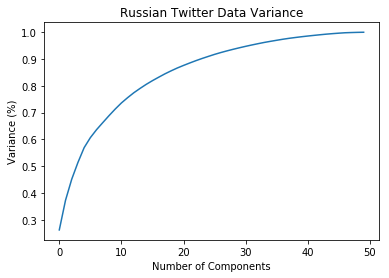

In [11]:
# Applied PCA
# VecMatrix Column 1 = classification, column 2:51 = variables

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(vecMatrix[:,1:51])
pca = PCA().fit(data_rescaled)
plt.figure()
plt.plot(numpy.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Russian Twitter Data Variance')
plt.show()


# Conclusion: Seems pointless. 90% of variation is characterized by 30/50 components

In [9]:

## Preprepare data 60:20:20
test_size = .2
sample_num = numpy.size(vecMatrix,0)
numpy.random.shuffle(vecMatrix)

train_x = vecMatrix[:int(test_size*sample_num),1:]
train_y = vecMatrix[:int(test_size*sample_num),0]

test_x = vecMatrix[int(test_size*sample_num)+1:,1:]
test_y = vecMatrix[int(test_size*sample_num)+1:,0]


from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
train_y = lab_enc.fit_transform(train_y)
test_y = lab_enc.fit_transform(test_y)

In [13]:
### SVM

from sklearn import svm, metrics

clf = svm.SVC(kernel='linear',gamma='auto')
clf.fit(train_x, train_y) 

pred_y = clf.predict(test_x)


from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_y, pred_y)
print(confusion)
true_neg = float(confusion[0][0])
true_pos = float(confusion[1][1])
false_neg = float(confusion[1][0])
false_pos = float(confusion[0][1])
total = true_neg+true_pos+false_neg+false_pos

print("Total Accuracy % = " + str((true_pos+true_neg)/total))
print("Precision % = " + str(true_pos/(true_pos+false_pos)))
print("Recall % = " + str(true_pos/(false_neg+true_pos)))
print("False Positive % = " + str(false_pos/total) )
print("False Negative % = " + str(false_neg/total) )





[[117541  20402]
 [ 13128 138895]]
Total Accuracy % = 0.884365753226
Precision % = 0.871924769456
Recall % = 0.913644645876
False Positive % = 0.0703599732382
False Negative % = 0.0452742735355


In [15]:
### Naive Bayes
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics

clf = GaussianNB()
clf.fit(train_x, train_y) 

pred_y = clf.predict(test_x)


from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_y, pred_y)
print(confusion)
true_neg = float(confusion[0][0])
true_pos = float(confusion[1][1])
false_neg = float(confusion[1][0])
false_pos = float(confusion[0][1])
total = true_neg+true_pos+false_neg+false_pos

print("Total Accuracy % = " + str((true_pos+true_neg)/total))
print("Precision % = " + str(true_pos/(true_pos+false_pos)))
print("Recall % = " + str(true_pos/(false_neg+true_pos)))
print("False Positive % = " + str(false_pos/total) )
print("False Negative % = " + str(false_neg/total) )





[[110384  27559]
 [ 18259 133764]]
Total Accuracy % = 0.84198837105
Precision % = 0.829168810399
Recall % = 0.879893174059
False Positive % = 0.0950421773587
False Negative % = 0.0629694515909


In [10]:
### KNN

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x,train_y)

pred_y= model.predict(test_x)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_y, pred_y)
print(confusion)
true_neg = confusion[0][0]
true_pos = confusion[1][1]
false_neg = confusion[1][0]
false_pos = confusion[0][1]
total = true_neg+true_pos+false_neg+false_pos

print("Total Accuracy % = " + str((true_pos+true_neg)/total))
print("Precision % = " + str(true_pos/(true_pos+false_pos)))
print("Recall % = " + str(true_pos/(false_neg+true_pos)))
print("False Positive % = " + str(false_pos/total) )
print("False Negative % = " + str(false_neg/total) )


[[119185  18758]
 [ 16973 135050]]
Total Accuracy % = 0
Precision % = 0
Recall % = 0
False Positive % = 0
False Negative % = 0


In [11]:
## LogReg

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_x,train_y)

pred_y= model.predict(test_x)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_y, pred_y)
print(confusion)
true_neg = confusion[0][0]
true_pos = confusion[1][1]
false_neg = confusion[1][0]
false_pos = confusion[0][1]
total = true_neg+true_pos+false_neg+false_pos

print("Total Accuracy % = " + str((true_pos+true_neg)/total))
print("Precision % = " + str(true_pos/(true_pos+false_pos)))
print("Recall % = " + str(true_pos/(false_neg+true_pos)))
print("False Positive % = " + str(false_pos/total) )
print("False Negative % = " + str(false_neg/total) )


[[118988  18955]
 [ 14955 137068]]
Total Accuracy % = 0
Precision % = 0
Recall % = 0
False Positive % = 0
False Negative % = 0


In [2]:
vecMatrix


NameError: name 'vecMatrix' is not defined